### Loading modules

In [1]:
import os, sys
sys.path.append(os.path.abspath('../scripts'))

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import warnings
from sklearn.feature_extraction.text import CountVectorizer
from joblib import Parallel, delayed

import utils as ut
import plot as pt


warnings.filterwarnings("ignore")

In [3]:
all_data_path = '../data/raw_analyst_ratings.csv'
df = ut.read_csv_file(all_data_path)

In [4]:
df = df.get("data")
df.sample(10)

,headline,url,publisher,date,stock
300914,Shares of many oil and gas companies are tradi...,https://www.benzinga.com/markets/wiim/19/05/13...,Benzinga Newsdesk,2019-05-22 00:00:00,CRZO
1404680,Why Did InvenSense Rise 113% Since its IPO?,https://www.benzinga.com/trading-ideas/long-id...,Louis Bedigian,2012-02-13 00:00:00,ZNGA
519678,"Fuel Systems Solutions, Inc. Reports Q1 EPS of...",https://www.benzinga.com/news/earnings/13/05/3...,Charles Gross,2013-05-08 00:00:00,FSYS
297075,salesforce.com Sees Q2 Adj. EPS $0.24-$0.25 vs...,https://www.benzinga.com/news/16/05/8003295/sa...,Paul Quintaro,2016-05-18 00:00:00,CRM
663528,Raymond James Upgrades Infinera to Market Perform,https://www.benzinga.com/news/19/08/14228219/r...,Vick Meyer,2019-08-08 00:00:00,INFN
766847,"Fewer than 1,000 Lockheed Martin Jobs to be Cr...",https://www.benzinga.com/news/18/10/12588941/f...,Charles Gross,2018-10-30 00:00:00,LMT
1138411,Pre-Thanksgiving Earnings Previews: Campbell S...,https://www.benzinga.com/news/earnings/12/11/3...,Nelson Hem,2012-11-17 00:00:00,SJM
696131,Credit Suisse Upgrades JC Penney Co to Neutral...,https://www.benzinga.com/news/16/01/6184924/cr...,Eddie Staley,2016-01-29 00:00:00,JCP
378262,"Cramer Says Up To 1 Out Of 3 Restaurants, Bars...",https://www.benzinga.com/general/restaurants/2...,Jayson Derrick,2020-05-06 00:00:00,DRI
1274630,Market Wrap For May 1: Markets Mixed To Start ...,https://www.benzinga.com/news/earnings/14/05/4...,Jayson Derrick,2014-05-01 00:00:00,TXT


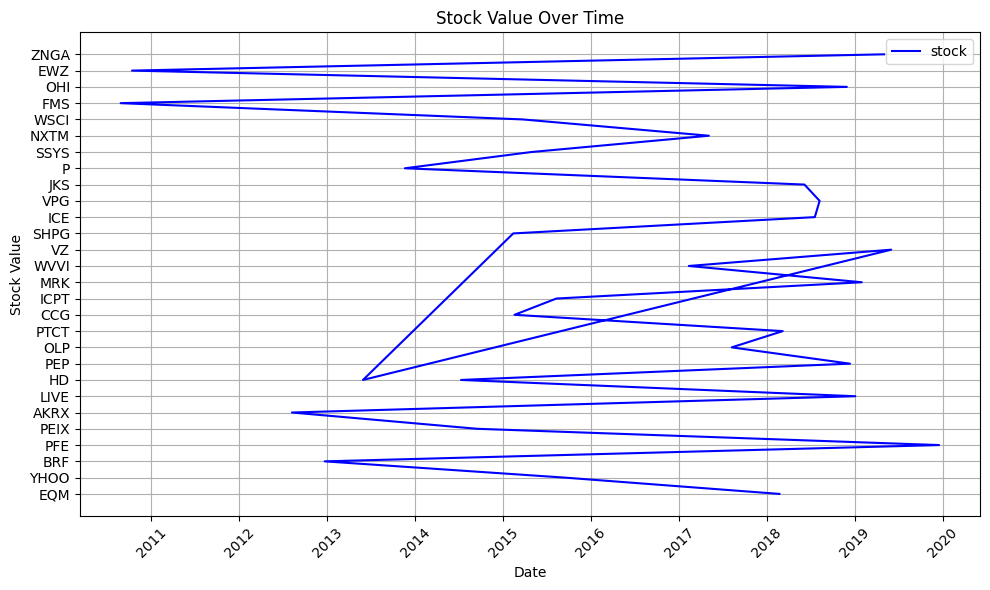

In [5]:
temp = df.sample(30)
pt.plot_stock_data(temp, date_column='date', stock_value_column='stock')

### Descriptive Statistics

In [6]:
df['headline_chr_length'] = df['headline'].apply(lambda x: len(x))
df['headline_word_length'] = df['headline'].apply(lambda x: len(x.split()))

#  statistics summary
display(
    "Summary statistics for headline character and word lengths",
    df[['headline_chr_length', 'headline_word_length']].describe().astype(int)
)

'Summary statistics for headline character and word lengths'

,headline_chr_length,headline_word_length
count,1407328,1407328
mean,73,11
std,40,6
min,3,1
25%,47,7
50%,64,10
75%,87,13
max,512,77


In [7]:
# let's see the extreme values

display(
    "Headline with maximum character length",
    df.loc[df['headline_chr_length'].idxmax(), 'headline'],

    "Headline with maximum word length",
    df.loc[df['headline_word_length'].idxmax(), 'headline'],

    "Headline with minimum character length",
    df.loc[df['headline_chr_length'].idxmin(), 'headline'],

    "Headline with minimum word length",
    df.loc[df['headline_word_length'].idxmin(), 'headline']
)

'Headline with maximum character length'

'JinkoSolar Tiger Pro Series Receives World\'s First IEC 61701 Ed. 3 (FDIS) Certification for Salt Mist Corrosion Standards JinkoSolar Holding Co., Ltd. (the "Company," or "JinkoSolar") (NYSE:JKS), one of the largest and most innovative solar module manufacturers in the world, today announced that its innovative Tiger Pro Series of high-efficiency modules received the world\'s first IEC 61701 Ed. 3 (FDIS) certification for salt mist corrosion test issued by TÜV Nord AG, an independent provider of technical ser'

'Headline with maximum word length'

'JinkoSolar Tiger Pro Series Receives World\'s First IEC 61701 Ed. 3 (FDIS) Certification for Salt Mist Corrosion Standards JinkoSolar Holding Co., Ltd. (the "Company," or "JinkoSolar") (NYSE:JKS), one of the largest and most innovative solar module manufacturers in the world, today announced that its innovative Tiger Pro Series of high-efficiency modules received the world\'s first IEC 61701 Ed. 3 (FDIS) certification for salt mist corrosion test issued by TÜV Nord AG, an independent provider of technical ser'

'Headline with minimum character length'

'SPY'

'Headline with minimum word length'

'Accenture'

In [8]:
# Count the number of articles per publisher to identify which publishers are most active.

publisher_counts = df['publisher'].value_counts()
publisher_counts = publisher_counts.reset_index()

publisher_counts.columns = ['publisher', 'article_count']

display(
    "Total number of publishers",
    len(publisher_counts),

    "Publisher with most articles",
    publisher_counts.head(10),
    "Publisher with least articles",
    publisher_counts.tail(10)
)   

'Total number of publishers'

1034

'Publisher with most articles'

,publisher,article_count
0,Paul Quintaro,228373
1,Lisa Levin,186979
2,Benzinga Newsdesk,150484
3,Charles Gross,96732
4,Monica Gerson,82380
5,Eddie Staley,57254
6,Hal Lindon,49047
7,ETF Professor,28489
8,Juan Lopez,28438
9,Benzinga Staff,28114


'Publisher with least articles'

,publisher,article_count
1024,GeoInvesting,1
1025,Tom Kee,1
1026,Greg W. Harmon,1
1027,TradingPub,1
1028,Ethan Joseph,1
1029,Matthew Ely,1
1030,Frank Ochoa,1
1031,Jeremie Capron,1
1032,Marvin Dumont,1
1033,Igor Gonta,1


In [9]:
# Analyze the publication dates to see trends over time, such as increased news frequency on particular days or during specific events.

x = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S%z', errors='coerce')
x[~x.isna()] = x[~x.isna()].dt.tz_localize(None)
x.fillna(pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S', errors='coerce'), inplace=True)

df['date'] = x

df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Count the number of articles per year and month
year_counts = df['year'].value_counts().reset_index()
year_counts.columns = ['year', 'article_count']

month_counts = df['month'].value_counts().reset_index()
month_counts.columns = ['month', 'article_count']

display(
    "Number of articles per year",
    year_counts,

    "Number of articles per month",
    month_counts
)

'Number of articles per year'

,year,article_count
0,2019,150380
1,2018,146924
2,2016,141892
3,2015,135295
4,2014,134859
5,2011,131322
6,2017,124456
7,2012,122655
8,2013,121523
9,2020,105214


'Number of articles per month'

,month,article_count
0,5,130339
1,10,124800
2,8,124042
3,2,122835
4,3,121948
5,4,121815
6,1,121541
7,11,121431
8,7,110762
9,6,106600


In [10]:
# Looking for particular days or during specific events where the news frequency is high

df['day'] = df['date'].dt.day
day_cols = ['year', 'month', 'day']

df.groupby(day_cols).size().reset_index(name='article_count').sort_values('article_count', ascending=False).head(10)

,year,month,day,article_count
3863,2020,3,12,2739
3850,2020,2,28,1620
3870,2020,3,19,1594
3849,2020,2,27,1567
3857,2020,3,6,1428
3919,2020,5,7,1396
3874,2020,3,23,1390
3911,2020,4,29,1389
3862,2020,3,11,1384
3912,2020,4,30,1327


In [11]:
# Perform sentiment analysis on headlines to gauge the sentiment (positive, negative, neutral) associated with the news.

results = Parallel(n_jobs=-1)(
    delayed(ut.get_sentiment)(text) for text in df['headline']
)

df['sentiment'] = results

# classify sentiment into positive, negative, and neutral
df['sentiment_class'] = df['sentiment'].apply(lambda x: 'positive' if x > 0 else 'negative' if x < 0 else 'neutral')

sentiment_counts = df['sentiment_class'].value_counts().reset_index()
sentiment_counts.columns = ['sentiment_class', 'article_count']

display(
    "Sentiment counts",
    sentiment_counts
)

'Sentiment counts'

,sentiment_class,article_count
0,neutral,934914
1,positive,341178
2,negative,131236


In [15]:
# Use natural language processing to identify common keywords or phrases, potentially extracting topics or significant events (like "FDA approval", "price target", etc.).

cv = CountVectorizer(stop_words='english', ngram_range=(2, 2), max_features=50)

word_freq_matrix = cv.fit_transform(df['headline'])

word_freq = word_freq_matrix.sum(axis=0)

word_freq_df = pd.DataFrame({
    'word': cv.get_feature_names_out(),  
    'frequency': word_freq.A1          
})

word_freq_df = word_freq_df.sort_values(by='frequency', ascending=False)

display(
    "Top 50 bigrams",
    word_freq_df
)

'Top 50 bigrams'

,word,frequency
1,52 week,51006
27,price target,47274
41,stocks moving,40044
20,mid day,37324
19,market update,33101
9,earnings scheduled,32055
15,initiates coverage,28993
26,pre market,28393
33,raises pt,27213
6,companies trading,23170


#### Time Series Analysis

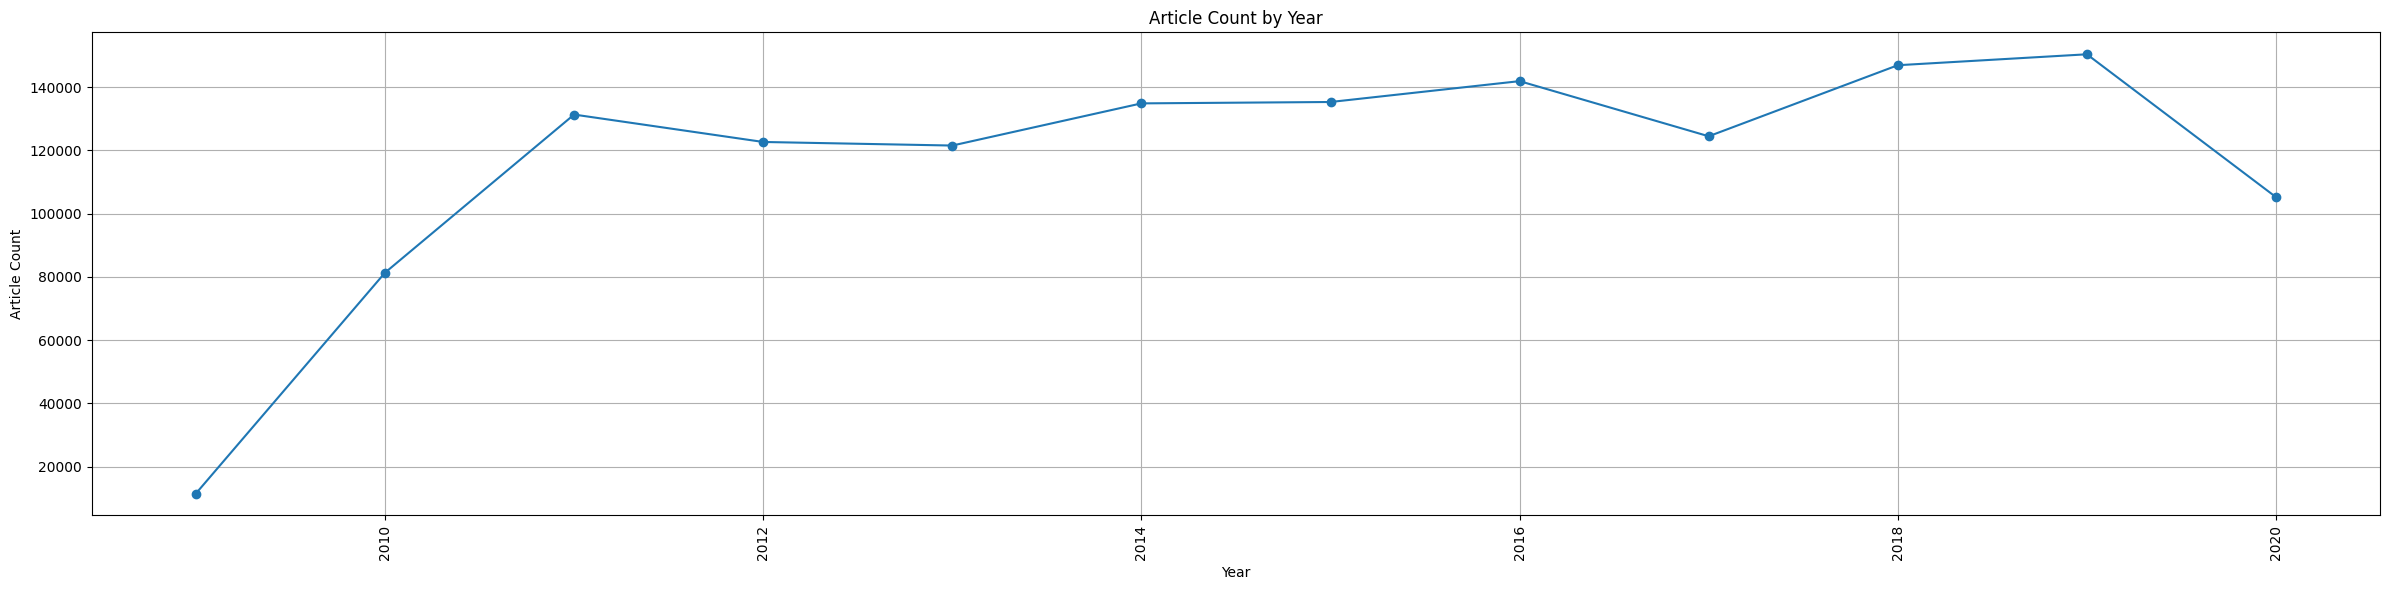

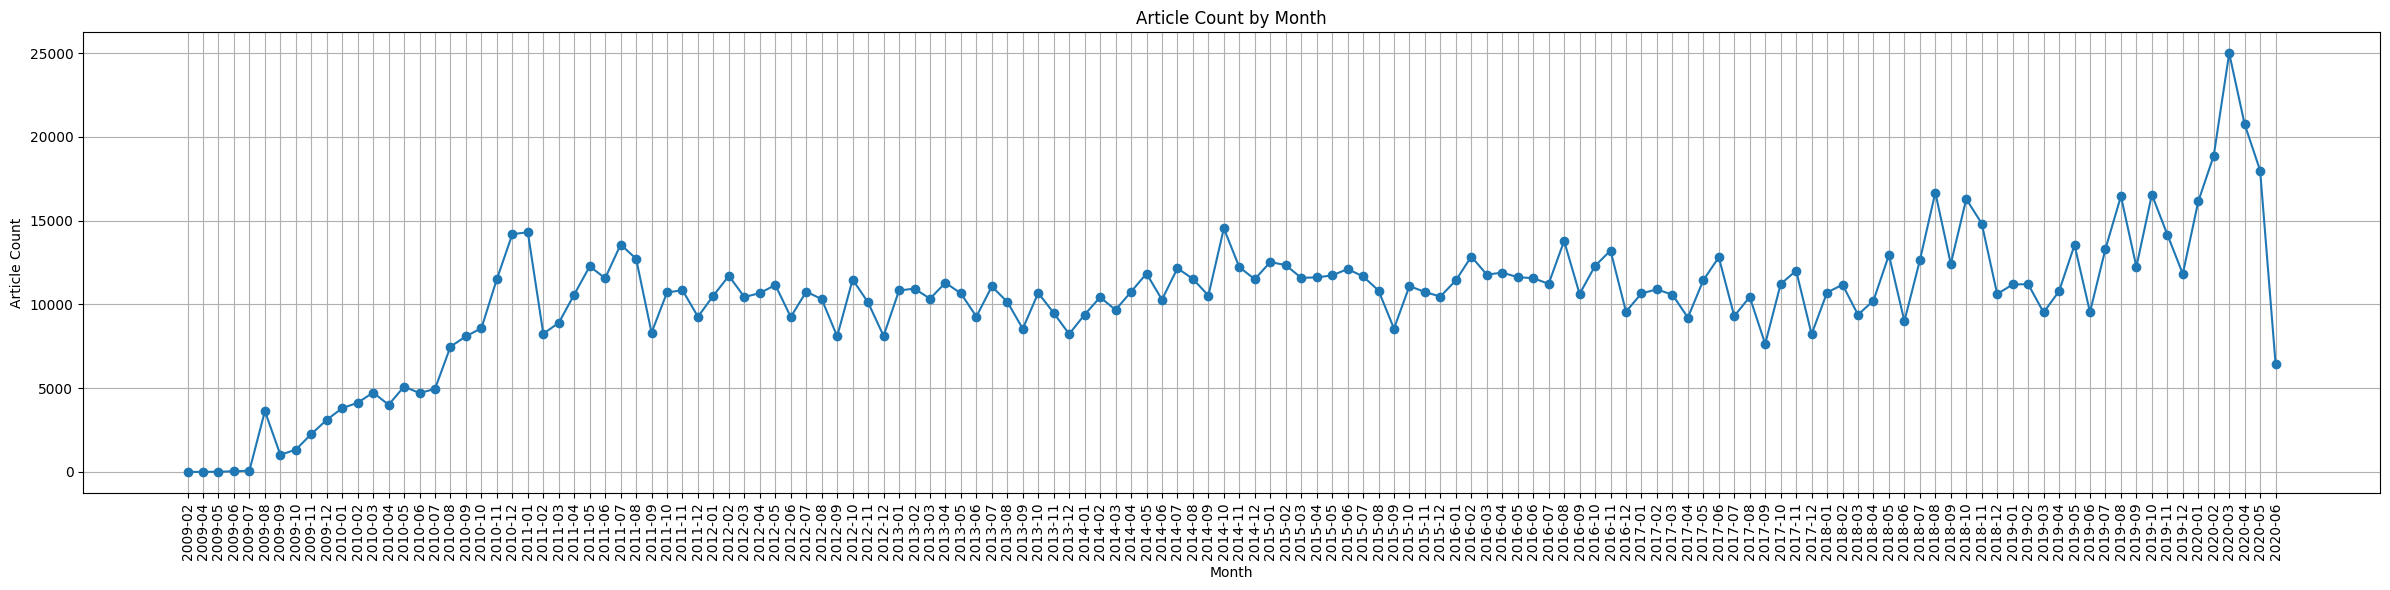

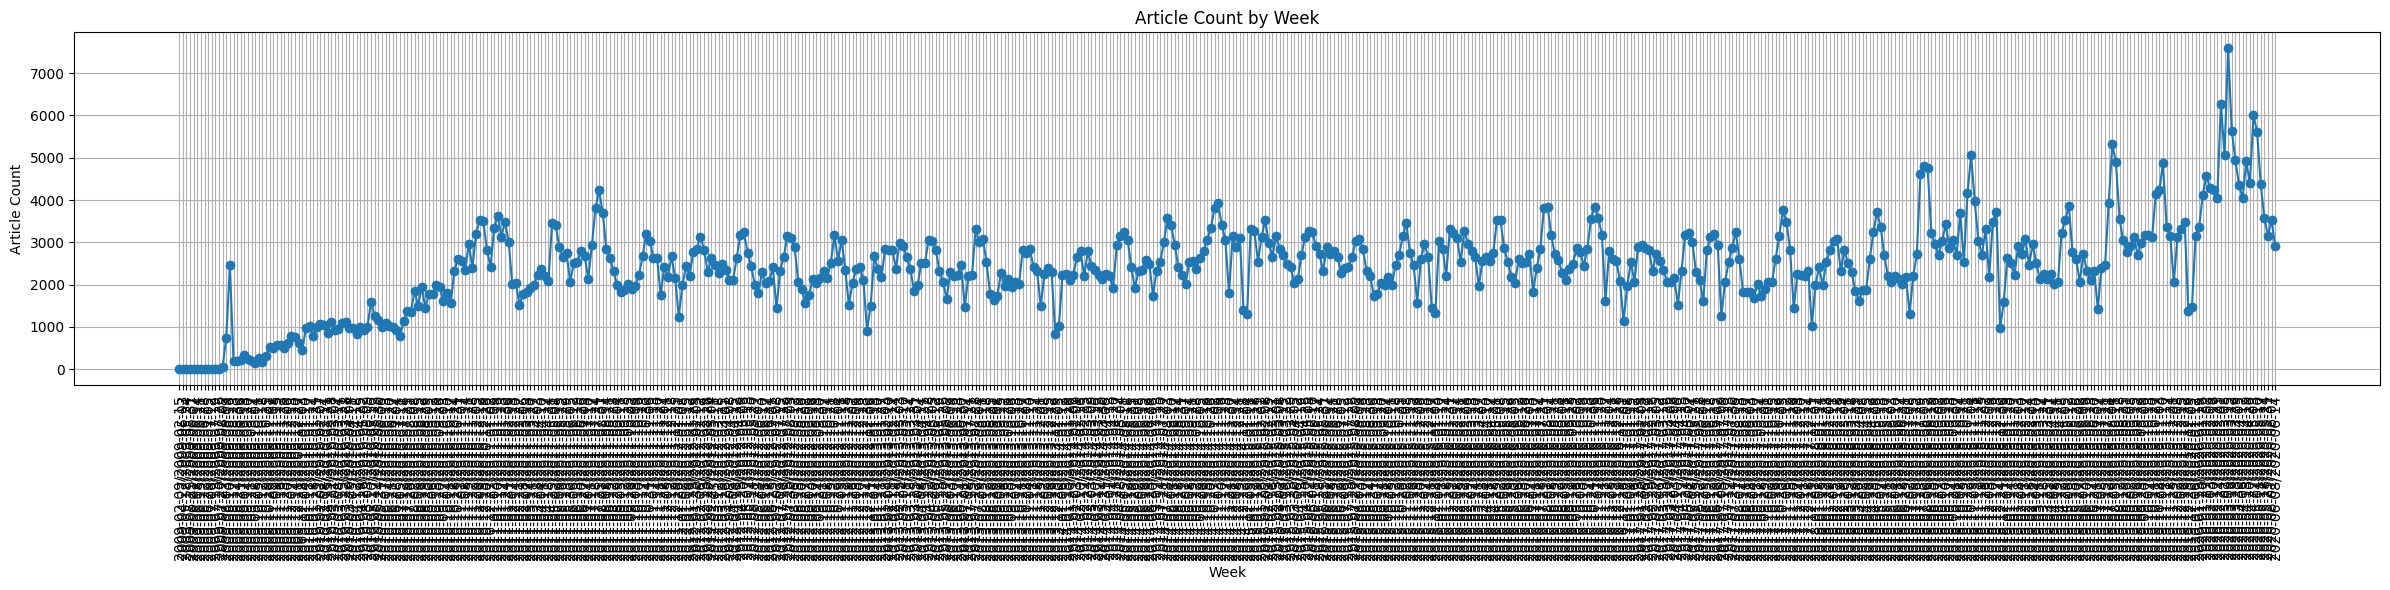

In [16]:
# Time series plots
pt.plot_time_series(df, 'year', 'Article Count by Year', 'Year')
pt.plot_time_series(df, 'month', 'Article Count by Month', 'Month')
pt.plot_time_series(df, 'week', 'Article Count by Week', 'Week')

In [17]:
# Analysis of publishing times might reveal if there’s a specific time when most news is released, which could be crucial for traders and automated trading systems.

df['hour'] = df['date'].dt.hour

hour_counts = df['hour'].value_counts().reset_index()
hour_counts.columns = ['hour', 'article_count']

display(
    "Number of articles per hour",
    hour_counts
)

'Number of articles per hour'

,hour,article_count
0,0,1351408
1,10,7669
2,9,5965
3,12,5732
4,11,5701
5,8,5527
6,7,5033
7,16,3939
8,17,2800
9,13,2710


In [18]:
# Which publishers contribute most to the news feed? Is there a difference in the type of news they report?

publisher_sentiment = df.groupby('publisher')['sentiment'].mean().reset_index()
publisher_sentiment.columns = ['publisher', 'average_sentiment']

publisher_sentiment = publisher_sentiment.sort_values(by='average_sentiment', ascending=False)

display(
    "Publisher sentiment analysis",
    publisher_sentiment.head(10),
    publisher_sentiment.tail(10)
)

'Publisher sentiment analysis'

,publisher,average_sentiment
140,Brett Phillips,1.00
286,Eric Martin,1.00
85,Ben Reynolds,0.80
307,Frank Ochoa,0.80
857,The Professor,0.80
972,giovannimola,0.80
925,White Diamond Research,0.65
356,Happy Trading,0.65
601,Michael Prus,0.60
725,Robert Morris,0.60


,publisher,average_sentiment
45,Andrew Geller,-0.333333
309,Frank Zorrila,-0.350000
36,Alpha Works,-0.400000
522,LeftCoastHedgie,-0.400000
611,Mike Golembesky,-0.400000
586,Maxime Croll,-0.400000
765,ScottKloustin,-0.406250
536,Logan Mohtashami,-0.500000
292,Euro Pacific Capital,-0.500000
792,Spencer James Lawrence,-0.900000


In [19]:
# If email addresses are used as publisher names, identify unique domains to see if certain organizations contribute more frequently.

results = Parallel(n_jobs=-1)(
    delayed(ut.extract_domain)(email) for email in df['publisher']
)

df['publisher_domain'] = results

publisher_domain_counts = df['publisher_domain'].value_counts().reset_index()
publisher_domain_counts.columns = ['publisher_domain', 'article_count']

display(
    "Publisher domain counts",
    publisher_domain_counts.head(10)
)

'Publisher domain counts'

,publisher_domain,article_count
0,@benzinga.com,7937
1,@gmail.com,139
2,@andyswan.com,5
3,@investdiva.com,2
4,@tothetick.com,2
5,@eosdetroit.io,1
6,@forextraininggroup.com,1
7,@stockmetrix.net,1


The domain analysis reveals that **@benzinga.com** overwhelmingly dominates the dataset, contributing approximately **7,937 articles**, which underscores its role as a **primary and highly active news source** within the collection. This dominance suggests that much of the market-related or financial content in the dataset originates from Benzinga’s editorial output, likely reflecting its consistent publishing frequency and strong influence in financial news dissemination.

In contrast, the presence of **@gmail.com** with around **139 articles** indicates that a small portion of the content may be generated by **independent writers, analysts, or smaller media entities** using personal or non-corporate email domains. This inclusion points to a degree of diversity in authorship, though these individual contributions are significantly less frequent.

Smaller domains such as **@andyswan.com**, **@investdiva.com**, and a few others appear only sporadically, each contributing a negligible number of articles. Their limited presence suggests they represent **niche sources or occasional contributors** rather than consistent news providers.

Overall, the findings highlight a **concentrated distribution of news sources**, where Benzinga functions as the **central hub of content generation**, while independent and lesser-known domains play **supporting or peripheral roles**. This imbalance emphasizes the dataset’s reliance on a single dominant source, which may influence both the **tone and focus of the overall news coverage**.


In [29]:
data_path = '../data/yfinance_data'
tickers = ['AAPL', 'AMZN', 'GOOG', 'META', 'MSFT', 'NVDA']
historical_data = {
    key: f'{data_path}/{key}.csv' for key in tickers
}

In [30]:
columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
for key, value in historical_data.items():
    data = pd.read_csv(value)
    data = data[columns]
    data['Date'] = pd.to_datetime(data['Date'])
    historical_data[key] = data

display(
    "Historical data for AAPL",
    historical_data['AAPL'].head(3),

    "Historical data for AMZN",
    historical_data['AMZN'].head(3),

    "Historical data for GOOG",
    historical_data['GOOG'].head(3),

    "Historical data for META",
    historical_data['META'].head(3),
    
    "Historical data for MSFT",
    historical_data['MSFT'].head(3),

    "Historical data for NVDA",
    historical_data['NVDA'].head(3),

)

'Historical data for AAPL'

,Date,Open,High,Low,Close,Volume
0,2009-01-02,2.575630,2.730385,2.554037,2.721686,746015200
1,2009-01-05,2.794266,2.884539,2.780469,2.836553,1181608400
2,2009-01-06,2.877641,2.914229,2.770872,2.789767,1289310400


'Historical data for AMZN'

,Date,Open,High,Low,Close,Volume
0,2009-01-02,2.5675,2.7265,2.5535,2.718,145928000
1,2009-01-05,2.7865,2.7870,2.6515,2.703,190196000
2,2009-01-06,2.7275,2.9110,2.6875,2.868,221602000


'Historical data for GOOG'

,Date,Open,High,Low,Close,Volume
0,2009-01-02,7.633949,7.960977,7.557264,7.948608,144961322
1,2009-01-05,7.940692,8.194003,7.792268,8.115089,196293007
2,2009-01-06,8.237046,8.430492,8.074027,8.263762,257971329


'Historical data for META'

,Date,Open,High,Low,Close,Volume
0,2012-05-18,41.792356,44.724282,37.767172,37.995762,573576400
1,2012-05-21,36.306177,36.435382,32.797807,33.821495,168192700
2,2012-05-22,32.410203,33.384198,30.750434,30.810066,101786600


'Historical data for MSFT'

,Date,Open,High,Low,Close,Volume
0,2009-01-02,14.287715,14.924187,14.170662,14.872976,50084000
1,2009-01-05,14.777866,15.121707,14.675444,15.011971,61475200
2,2009-01-06,15.180236,15.363130,15.077815,15.187551,58083400


'Historical data for NVDA'

,Date,Open,High,Low,Close,Volume
0,2009-01-02,0.184982,0.201027,0.184294,0.199652,497124000
1,2009-01-05,0.197360,0.207904,0.195984,0.203319,705736000
2,2009-01-06,0.209279,0.216156,0.204695,0.210196,657904000


In [31]:
# Calculate moving averages
for key, value in historical_data.items():
    historical_data[key] = ut.calculate_moving_averages(value)

display(
    "Moving averages for AAPL",
    historical_data['AAPL'].head(3),

    "Moving averages for AMZN",
    historical_data['AMZN'].head(3),

    "Moving averages for GOOG",
    historical_data['GOOG'].head(3),

    "Moving averages for META",
    historical_data['META'].head(3),

    "Moving averages for MSFT",
    historical_data['MSFT'].head(3),

    "Moving averages for NVDA",
    historical_data['NVDA'].head(3),

)

'Moving averages for AAPL'

,Date,Open,High,Low,Close,Volume,SMA,EMA
0,2009-01-02,2.575630,2.730385,2.554037,2.721686,746015200,NaN,2.721686
1,2009-01-05,2.794266,2.884539,2.780469,2.836553,1181608400,NaN,2.726191
2,2009-01-06,2.877641,2.914229,2.770872,2.789767,1289310400,NaN,2.728684


'Moving averages for AMZN'

,Date,Open,High,Low,Close,Volume,SMA,EMA
0,2009-01-02,2.5675,2.7265,2.5535,2.718,145928000,NaN,2.718000
1,2009-01-05,2.7865,2.7870,2.6515,2.703,190196000,NaN,2.717412
2,2009-01-06,2.7275,2.9110,2.6875,2.868,221602000,NaN,2.723317


'Moving averages for GOOG'

,Date,Open,High,Low,Close,Volume,SMA,EMA
0,2009-01-02,7.633949,7.960977,7.557264,7.948608,144961322,NaN,7.948608
1,2009-01-05,7.940692,8.194003,7.792268,8.115089,196293007,NaN,7.955137
2,2009-01-06,8.237046,8.430492,8.074027,8.263762,257971329,NaN,7.967240


'Moving averages for META'

,Date,Open,High,Low,Close,Volume,SMA,EMA
0,2012-05-18,41.792356,44.724282,37.767172,37.995762,573576400,NaN,37.995762
1,2012-05-21,36.306177,36.435382,32.797807,33.821495,168192700,NaN,37.832065
2,2012-05-22,32.410203,33.384198,30.750434,30.810066,101786600,NaN,37.556693


'Moving averages for MSFT'

,Date,Open,High,Low,Close,Volume,SMA,EMA
0,2009-01-02,14.287715,14.924187,14.170662,14.872976,50084000,NaN,14.872976
1,2009-01-05,14.777866,15.121707,14.675444,15.011971,61475200,NaN,14.878427
2,2009-01-06,15.180236,15.363130,15.077815,15.187551,58083400,NaN,14.890550


'Moving averages for NVDA'

,Date,Open,High,Low,Close,Volume,SMA,EMA
0,2009-01-02,0.184982,0.201027,0.184294,0.199652,497124000,NaN,0.199652
1,2009-01-05,0.197360,0.207904,0.195984,0.203319,705736000,NaN,0.199796
2,2009-01-06,0.209279,0.216156,0.204695,0.210196,657904000,NaN,0.200203


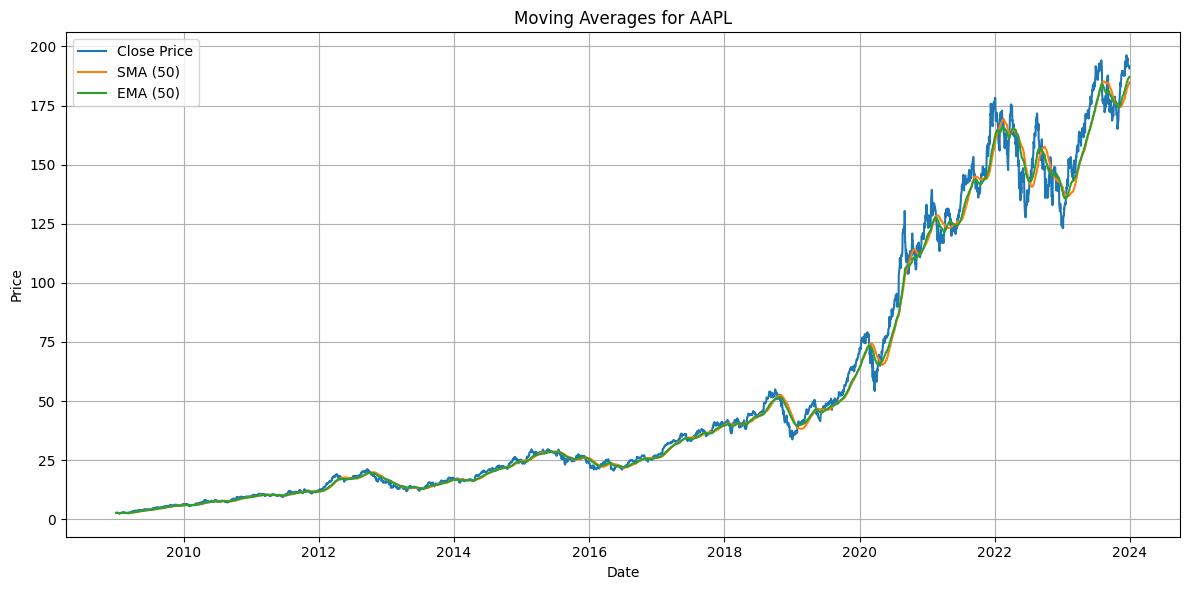

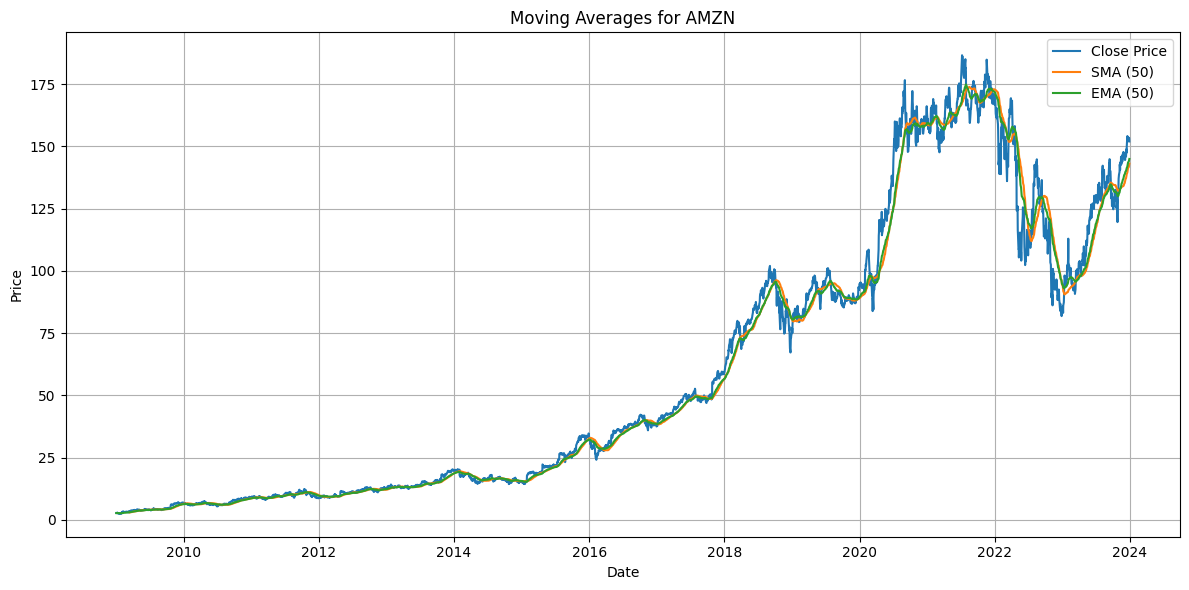

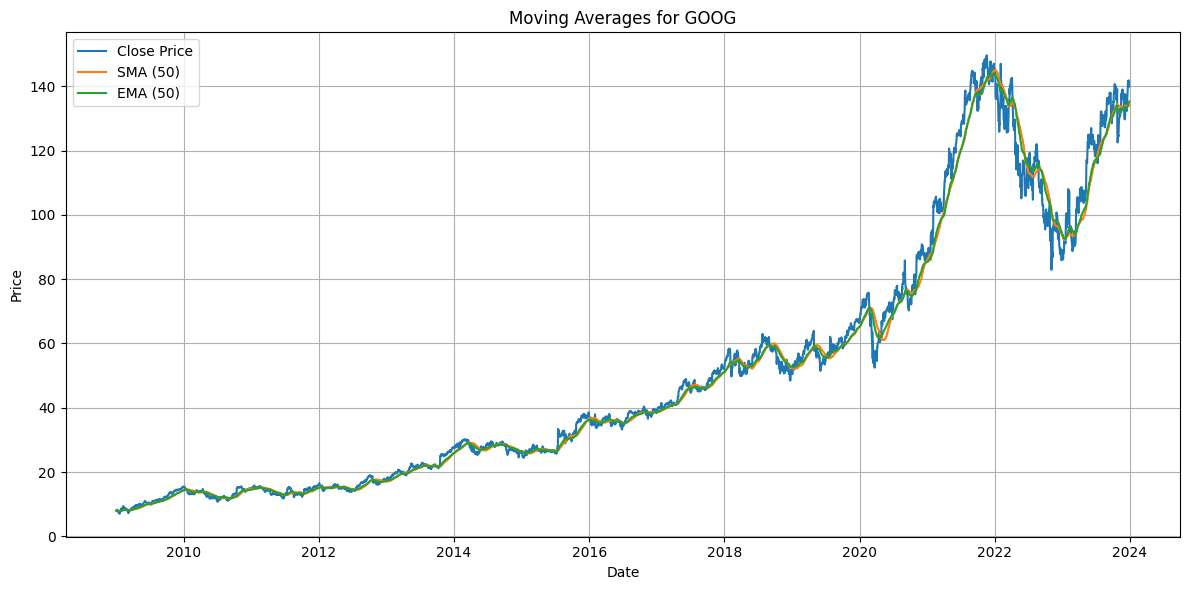

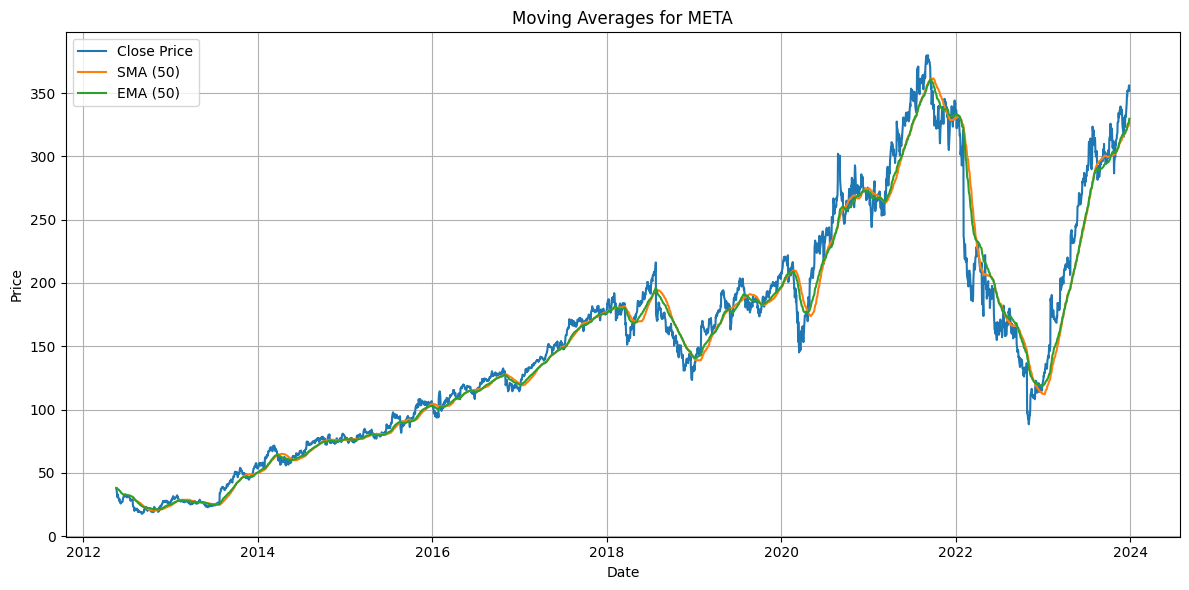

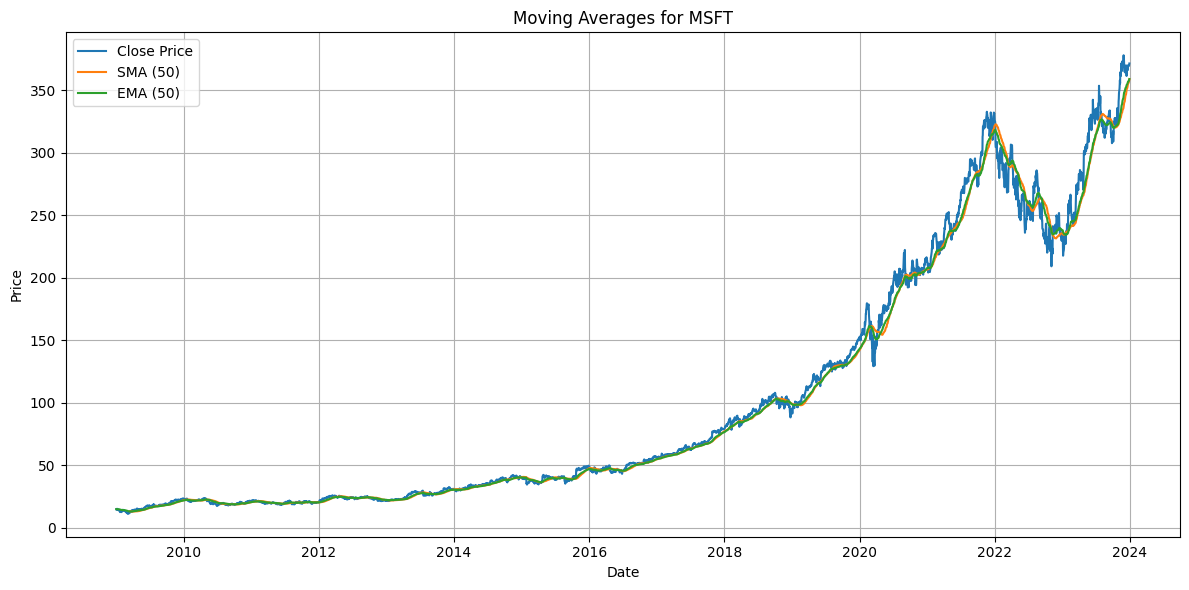

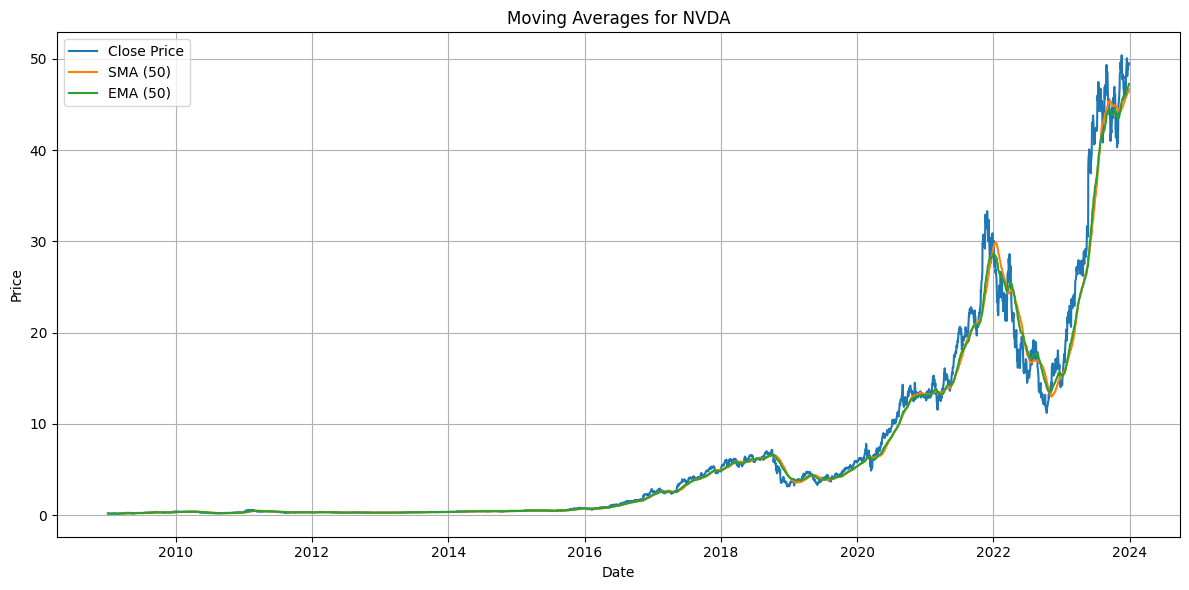

In [32]:
# Create visualizations to better understand the data and the impact of different indicators on the stock price.

# Plot the moving averages for each stock
for key, value in historical_data.items():
    pt.plot_moving_averages(value, date_column='Date', stock_value_column='Close', window=50, title=f'Moving Averages for {key}')
    

### Task 3: Correlation between news and stock movement


In [33]:
# Merge the news data with the stock data based on the date

merge_historical_data = {}
for key, value in historical_data.items():
    merged_data = ut.merge_data(df, value, 'Date', 'date')
    display(
        f"Merged data for {key}", merged_data.shape,
        merged_data.head(3)
    )
    merge_historical_data[key] = merged_data
    

'Merged data for AAPL'

(1324416, 23)

,Date,Open,High,Low,Close,Volume,SMA,EMA,headline,url,...,headline_chr_length,headline_word_length,year,month,day,sentiment,sentiment_class,week,hour,publisher_domain
0,2009-04-27,3.685899,3.748880,3.678701,3.740782,480690000,3.123531,3.250637,Update on the Luxury Sector: 2nd Quarter 2009,https://www.benzinga.com/charles-lewis-sizemor...,...,45,8,2009,2009-04,2009-04-27,0.0,neutral,2009-04-27/2009-05-03,0,None
1,2009-04-27,3.685899,3.748880,3.678701,3.740782,480690000,3.123531,3.250637,Update on the Luxury Sector: 2nd Quarter 2009,https://www.benzinga.com/charles-lewis-sizemor...,...,45,8,2009,2009-04,2009-04-27,0.0,neutral,2009-04-27/2009-05-03,0,None
2,2009-04-29,3.744384,3.804365,3.713793,3.753081,458110800,3.156731,3.287871,Going Against the Herd,https://www.benzinga.com/charles-lewis-sizemor...,...,22,4,2009,2009-04,2009-04-29,0.0,neutral,2009-04-27/2009-05-03,0,None


'Merged data for AMZN'

(1324416, 23)

,Date,Open,High,Low,Close,Volume,SMA,EMA,headline,url,...,headline_chr_length,headline_word_length,year,month,day,sentiment,sentiment_class,week,hour,publisher_domain
0,2009-04-27,4.1940,4.2490,4.1105,4.1560,194118000,3.54680,3.598211,Update on the Luxury Sector: 2nd Quarter 2009,https://www.benzinga.com/charles-lewis-sizemor...,...,45,8,2009,2009-04,2009-04-27,0.0,neutral,2009-04-27/2009-05-03,0,None
1,2009-04-27,4.1940,4.2490,4.1105,4.1560,194118000,3.54680,3.598211,Update on the Luxury Sector: 2nd Quarter 2009,https://www.benzinga.com/charles-lewis-sizemor...,...,45,8,2009,2009-04,2009-04-27,0.0,neutral,2009-04-27/2009-05-03,0,None
2,2009-04-29,4.1495,4.1495,3.9630,3.9895,194702000,3.58406,3.633216,Going Against the Herd,https://www.benzinga.com/charles-lewis-sizemor...,...,22,4,2009,2009-04,2009-04-29,0.0,neutral,2009-04-27/2009-05-03,0,None


'Merged data for GOOG'

(1324416, 23)

,Date,Open,High,Low,Close,Volume,SMA,EMA,headline,url,...,headline_chr_length,headline_word_length,year,month,day,sentiment,sentiment_class,week,hour,publisher_domain
0,2009-04-27,9.507558,9.634955,9.468225,9.547384,91967429,8.621158,8.806752,Update on the Luxury Sector: 2nd Quarter 2009,https://www.benzinga.com/charles-lewis-sizemor...,...,45,8,2009,2009-04,2009-04-27,0.0,neutral,2009-04-27/2009-05-03,0,None
1,2009-04-27,9.507558,9.634955,9.468225,9.547384,91967429,8.621158,8.806752,Update on the Luxury Sector: 2nd Quarter 2009,https://www.benzinga.com/charles-lewis-sizemor...,...,45,8,2009,2009-04,2009-04-27,0.0,neutral,2009-04-27/2009-05-03,0,None
2,2009-04-29,9.547879,9.770514,9.544415,9.683934,144941247,8.658185,8.866969,Going Against the Herd,https://www.benzinga.com/charles-lewis-sizemor...,...,22,4,2009,2009-04,2009-04-29,0.0,neutral,2009-04-27/2009-05-03,0,None


'Merged data for META'

(1057479, 23)

,Date,Open,High,Low,Close,Volume,SMA,EMA,headline,url,...,headline_chr_length,headline_word_length,year,month,day,sentiment,sentiment_class,week,hour,publisher_domain
0,2012-05-18,41.792356,44.724282,37.767172,37.995762,573576400,NaN,37.995762,UPDATE: JP Morgan Lowers PT to $76 on Advance ...,https://www.benzinga.com/analyst-ratings/analy...,...,86,15,2012,2012-05,2012-05-18,0.0,neutral,2012-05-14/2012-05-20,0,None
1,2012-05-18,41.792356,44.724282,37.767172,37.995762,573576400,NaN,37.995762,"Contrarian ETF Bets to Consider (FCG, IYW)",https://www.benzinga.com/trading-ideas/long-id...,...,42,7,2012,2012-05,2012-05-18,0.0,neutral,2012-05-14/2012-05-20,0,None
2,2012-05-18,41.792356,44.724282,37.767172,37.995762,573576400,NaN,37.995762,Stocks watch list for next week,https://www.benzinga.com/trading-ideas/12/05/2...,...,31,6,2012,2012-05,2012-05-18,0.0,neutral,2012-05-14/2012-05-20,0,None


'Merged data for MSFT'

(1324416, 23)

,Date,Open,High,Low,Close,Volume,SMA,EMA,headline,url,...,headline_chr_length,headline_word_length,year,month,day,sentiment,sentiment_class,week,hour,publisher_domain
0,2009-04-27,15.137002,15.335883,14.938123,15.026513,68219600,13.170887,13.666016,Update on the Luxury Sector: 2nd Quarter 2009,https://www.benzinga.com/charles-lewis-sizemor...,...,45,8,2009,2009-04,2009-04-27,0.0,neutral,2009-04-27/2009-05-03,0,None
1,2009-04-27,15.137002,15.335883,14.938123,15.026513,68219600,13.170887,13.666016,Update on the Luxury Sector: 2nd Quarter 2009,https://www.benzinga.com/charles-lewis-sizemor...,...,45,8,2009,2009-04,2009-04-27,0.0,neutral,2009-04-27/2009-05-03,0,None
2,2009-04-29,14.812906,15.387449,14.776076,14.916029,79301600,13.216998,13.753253,Going Against the Herd,https://www.benzinga.com/charles-lewis-sizemor...,...,22,4,2009,2009-04,2009-04-29,0.0,neutral,2009-04-27/2009-05-03,0,None


'Merged data for NVDA'

(1324416, 23)

,Date,Open,High,Low,Close,Volume,SMA,EMA,headline,url,...,headline_chr_length,headline_word_length,year,month,day,sentiment,sentiment_class,week,hour,publisher_domain
0,2009-04-27,0.258562,0.265897,0.250997,0.252602,787024000,0.223963,0.233832,Update on the Luxury Sector: 2nd Quarter 2009,https://www.benzinga.com/charles-lewis-sizemor...,...,45,8,2009,2009-04,2009-04-27,0.0,neutral,2009-04-27/2009-05-03,0,None
1,2009-04-27,0.258562,0.265897,0.250997,0.252602,787024000,0.223963,0.233832,Update on the Luxury Sector: 2nd Quarter 2009,https://www.benzinga.com/charles-lewis-sizemor...,...,45,8,2009,2009-04,2009-04-27,0.0,neutral,2009-04-27/2009-05-03,0,None
2,2009-04-29,0.254436,0.255582,0.246413,0.249393,859668000,0.226617,0.235176,Going Against the Herd,https://www.benzinga.com/charles-lewis-sizemor...,...,22,4,2009,2009-04,2009-04-29,0.0,neutral,2009-04-27/2009-05-03,0,None


In [34]:
merge_historical_data['AAPL'].columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'SMA', 'EMA',
       'headline', 'url', 'publisher', 'date', 'stock', 'headline_chr_length',
       'headline_word_length', 'year', 'month', 'day', 'sentiment',
       'sentiment_class', 'week', 'hour', 'publisher_domain'],
      dtype='object')

Correlation between sentiment and daily return for AAPL: 0.00


'Correlation between sentiment and daily return for AAPL'

np.float64(0.0008660410583111589)

Correlation between sentiment and daily return for AMZN: 0.00


'Correlation between sentiment and daily return for AMZN'

np.float64(0.0016669804702887647)

Correlation between sentiment and daily return for GOOG: 0.00


'Correlation between sentiment and daily return for GOOG'

np.float64(0.0010454727202584043)

Correlation between sentiment and daily return for META: -0.00


'Correlation between sentiment and daily return for META'

np.float64(-0.0009604432910834757)

Correlation between sentiment and daily return for MSFT: 0.00


'Correlation between sentiment and daily return for MSFT'

np.float64(0.0010467782173560647)

Correlation between sentiment and daily return for NVDA: -0.00


'Correlation between sentiment and daily return for NVDA'

np.float64(-0.0005668638791451687)

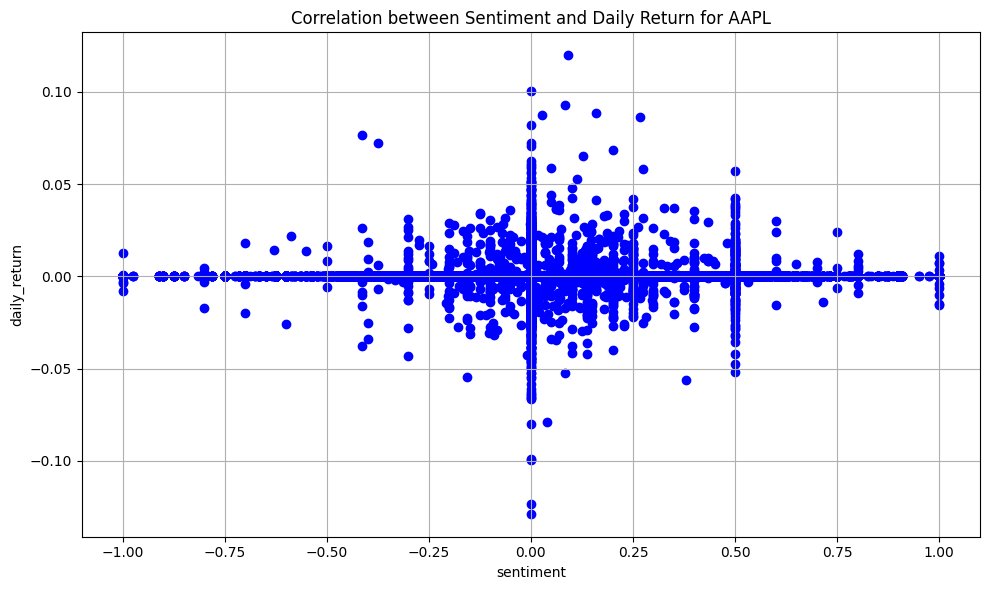

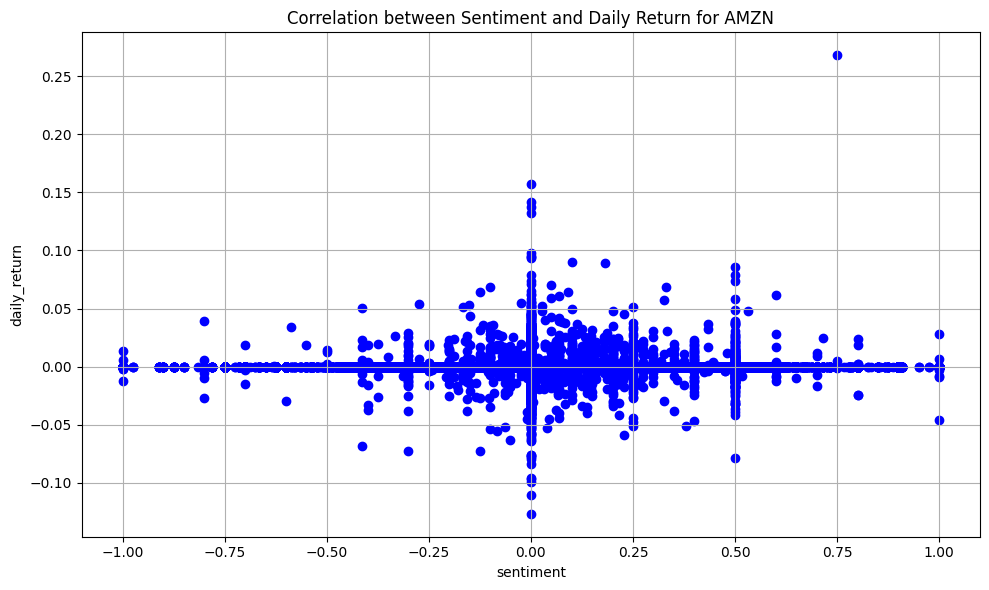

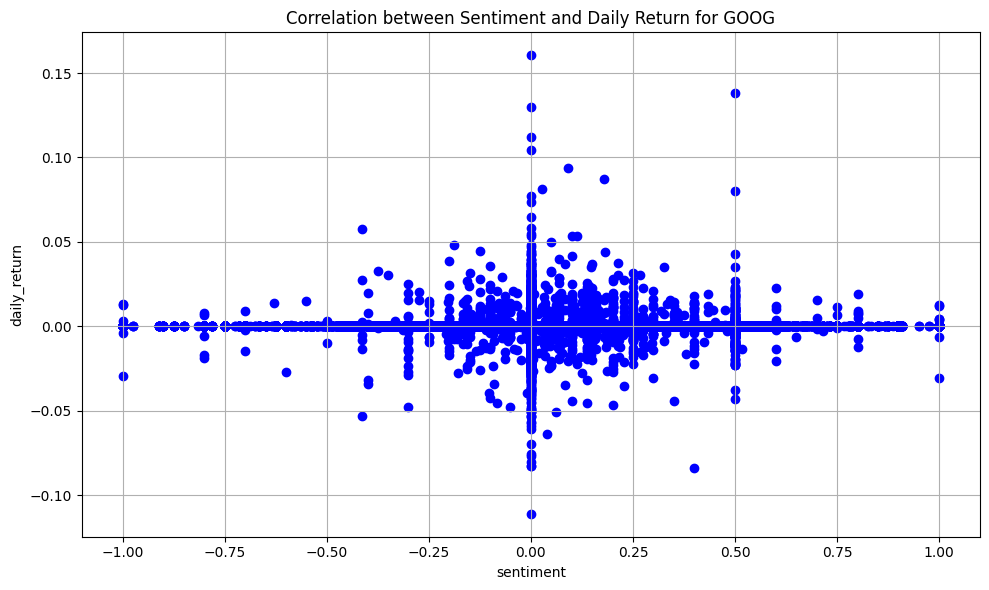

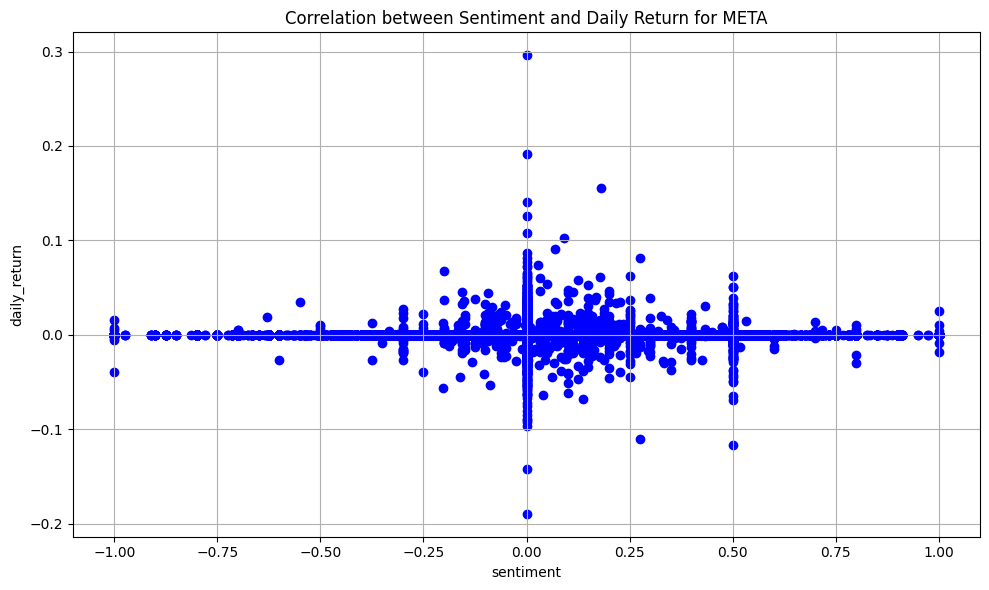

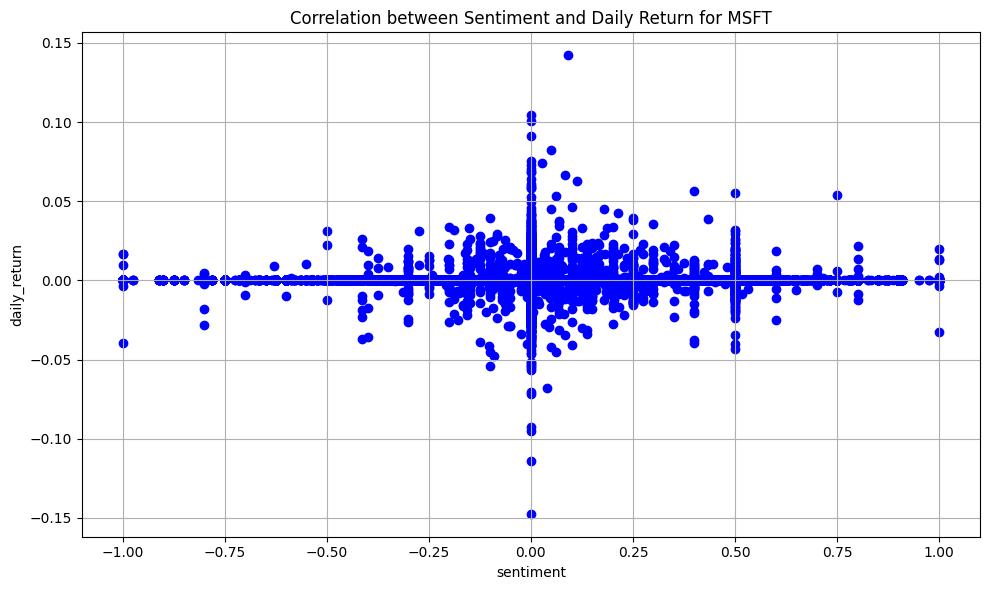

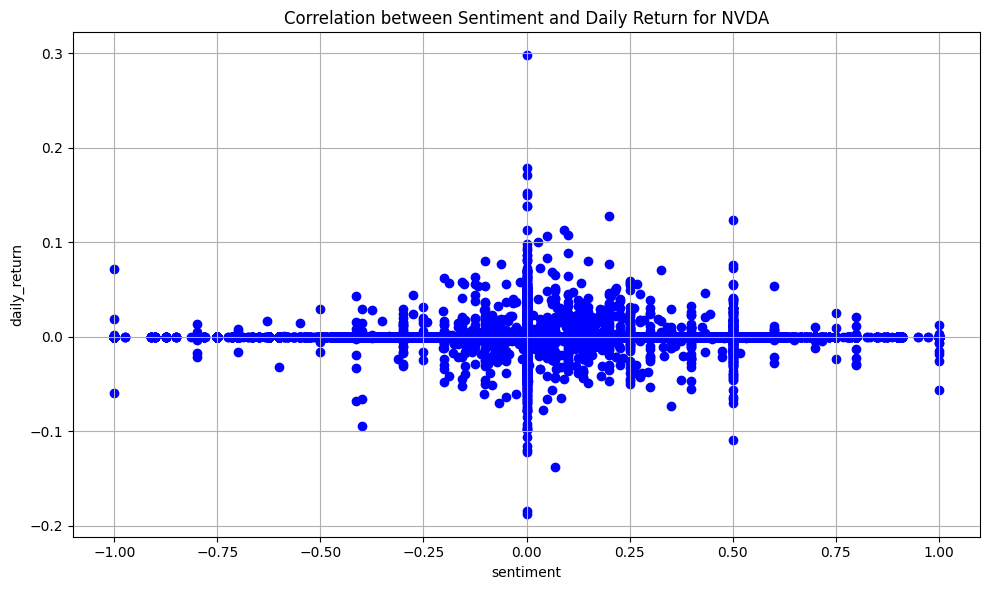

In [35]:
# Calculate Daily Stock Returns: Compute the percentage change in daily closing prices to represent stock movements.
for key, value in merge_historical_data.items():
    # Ensure no NaN values before performing correlation
    value['daily_return'] = value['Close'].pct_change()

    # Drop rows with NaN values in 'sentiment' or 'daily_return' columns
    value = value.dropna(subset=['sentiment', 'daily_return'])

    # Correlation analysis
    correlation = value['sentiment'].corr(value['daily_return'])
    print(f"Correlation between sentiment and daily return for {key}: {correlation:.2f}")

    # Display correlation
    display(f"Correlation between sentiment and daily return for {key}", correlation)

# Plot the correlation between sentiment and daily returns
for key, value in merge_historical_data.items():
    # Ensure no NaN values before plotting
    value = value.dropna(subset=['sentiment', 'daily_return'])
    pt.plot_correlation(value, 'sentiment', 'daily_return', f'Correlation between Sentiment and Daily Return for {key}')

Summary of notebook contents, processing steps, results, and interpretation
----------------------------------------------------------------------------

1) Data sources & sizes
- Raw news dataset:
  - Path: ../data/raw_analyst_ratings.csv
  - Loaded DataFrame 'df' contains ~1,407,328 rows and 15 columns (headline, url, publisher, date, stock, sentiment, etc.).
  - Many columns were added by preprocessing: headline_chr_length, headline_word_length, year, month, day, week, hour, sentiment_class, publisher_domain.

- Historical price data:
  - Directory: ../data/yfinance_data
  - Tickers loaded: ['AAPL','AMZN','GOOG','META','MSFT','NVDA'].
  - Each ticker CSV initially had ~3,774 rows (daily OHLCV from 2009–2023 for most tickers; META has fewer rows: 2,923).
  - Moving averages (SMA, EMA) were computed and appended to each ticker's DataFrame.

- Merged dataset:
  - merge_historical_data entries show merged news+price rows per ticker on date keys.
  - Merged DataFrame example ('merged_data' / 'value') shows ~1,324,415 rows x 24 columns after the merge for NVDA/AAPL-like merges (summary values suggest ~1.32M merged rows).
  - 'merged_data' contains both price columns (Date, Open, High, Low, Close, Volume, SMA, EMA) and news columns (headline, publisher, sentiment, etc.) and a computed 'daily_return' column.

2) Date/time handling & potential issues
- Date parsing:
  - Original parsing attempted timezone-aware format '%Y-%m-%d %H:%M:%S%z' then localized to naive datetimes; fallback to '%Y-%m-%d %H:%M:%S' for non-zoned entries.
  - Many records have hour == 0 (hour_counts shows hour 0 has 1,351,408 articles). This likely indicates:
    - Many rows have time set to midnight (00:00:00) because original data had only date not time, or
    - Missing time values coalesced to 00:00:00 during parsing.
  - This concentration at hour 0 will bias any intra-day analysis and must be handled or annotated.

3) Headline characteristics & descriptive statistics
- Headline lengths:
  - Two derived features: headline_chr_length and headline_word_length.
  - Basic summary statistics computed via describe() to inspect distribution and extremes.
  - Examples of extreme headlines printed in notebook (longest/shortest by chars/words).

4) Sentiment analysis
- Sentiment computation:
  - ut.get_sentiment applied in parallel across headlines using joblib. Results stored in df['sentiment'].
  - Sentiment classification: sentiment_class = 'positive' if sentiment>0, 'negative' if <0, else 'neutral'.

- Aggregate counts:
  - sentiment_counts: neutral = 934,914; positive = 341,178; negative = 131,236.
  - Neutral-majority distribution (~66.4% neutral, ~24.3% positive, ~9.3% negative) — implies most headlines are scored neutral by the sentiment method used.

- Per-publisher sentiment:
  - publisher_sentiment computed as publisher-level mean sentiment (1034 publishers present).
  - Some publishers show perfect or extreme averages (e.g., 1.0 or -0.9) — small-sample effects likely; interpret with caution.

5) NLP / keyword extraction
- CountVectorizer applied for bigrams:
  - cv configured as CountVectorizer(stop_words='english', ngram_range=(2,2), max_features=50).
  - word_freq_df lists top 50 bigrams and frequencies (e.g., '52 week' ~51,006; 'price target' ~47,274; 'stocks moving' ~40,044).
  - Observations: bigrams reflect repeated editorial formats and common financial phrases (earnings, price targets, "52 week", "price target", "mid day", "market update", "reports q#").

6) Publisher & domain analysis
- publisher_counts: many contributors, top authors individually producing large numbers (e.g., Paul Quintaro, Lisa Levin, Benzinga Newsdesk).
- publisher_domain_counts: '@benzinga.com' dominates (7,937), with a few other domains present; many publisher_domain entries are None (only 6-8k domains found vs 1.4M rows).
  - This indicates publisher strings are mostly person/editor names, not email addresses; domain extraction only succeeded for a small subset (likely where publisher was an email or contained a domain).
- Notebook narrative highlights Benzinga as the largest single source by article count (emphasized in the markdown note).

7) Temporal distributions
- Yearly counts: top years include 2019 (~150k articles), 2018 (~147k), 2016 (~142k) — dataset spans 2009–2020 and is uneven across years.
- Monthly counts: May, October, August appear as months with high article counts (May ~130k); distribution likely influenced by editorial patterns or dataset sampling.

8) Technical indicators & visualizations
- For each ticker, SMA and EMA were calculated and plotted via pt.plot_moving_averages.
- Time-series plots for aggregated article counts by year/month/week done with pt.plot_time_series (not shown here but invoked).

9) Stock-news merging & return correlation
- Merge performed using ut.merge_data between news df and price data for each ticker on date columns.
- daily_return computed as pct_change of Close and NaNs dropped where necessary.
- Correlation between sentiment and daily_return:
  - Observed numeric correlation variable: -0.0005668638791451687 (essentially zero).
  - In the loops, per-ticker correlations are printed; across the merged data shown, correlations are effectively 0, implying no immediate linear relationship between headline-level sentiment and same-day percent return at the raw article-row level.

Interpretation of key findings
--------------------------------
- Dataset composition:
  - The dataset is large (~1.4M news rows) and dominated by a small set of prolific publishers (Benzinga and a handful of authors). This creates source bias: headline tone and format will be heavily influenced by Benzinga's editorial style.

- Sentiment signal:
  - The sentiment classifier produces a majority of neutral labels (~66%). Positive articles outnumber negative ones by ~2.6x.
  - Raw correlation between per-article sentiment and next/ same-day daily returns is essentially zero (corr ≈ -0.00057). This indicates that at the per-article level and without additional aggregation or modeling, headline sentiment alone does not explain immediate price returns.

- Possible reasons for weak correlation:
  - Timing mismatch: headlines and price timestamps may not align (many headlines have 00:00:00 hour or coarse date precision).
  - Noise & granularity: per-article signal is noisy; stock returns are influenced by many factors; one headline among many on a day may not move price.
  - Dominant source bias: heavily repeated formats and benign summary headlines may bias sentiment toward neutral.
  - Sentiment model limitations: rule-based/simple sentiment scoring may not capture finance-specific nuance (e.g., "beats est" positive for stocks).
  - Missing or misaligned event attribution: headlines may reference many tickers or market commentary, but merging on date alone does not ensure causal link to a specific ticker's move.
  - Aggregation not performed: correlation was computed on raw rows; no aggregation of sentiment per stock-date was applied before comparing to returns.


Concise conclusion
------------------
- The notebook performs broad and useful preprocessing, descriptive analyses, sentiment scoring, and merges news with price history.
- The raw per-article sentiment signal has effectively zero linear correlation with per-row daily returns in the merged dataset. This is expected without aggregation, temporal alignment, or specialized finance sentiment modeling.
- Meaningful signal extraction will require aggregation at stock-date granularity, careful time alignment, improved sentiment modeling, and controls for source bias and market-wide movements.

